<a href="https://colab.research.google.com/github/WeegorMartins/Previs-o-de-tempo-de-entrega-de-pedidos-de-delivery/blob/main/Previs%C3%A3o_de_tempo_de_entrega_de_pedidos_de_delivery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de Tempo de Entrega no Estilo iFood

Este notebook tem como objetivo construir um modelo de machine learning para prever o tempo de entrega de pedidos em um cenário de aplicativo de delivery, utilizando variáveis logísticas, climáticas, operacionais e sazonais. Inspirado em um contexto de negócio do iFood.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# Carregamento e Pré-processamento dos Dados

In [8]:
df = pd.read_csv('/content/train.csv')

In [9]:
df['Time_taken(min)'] = df['Time_taken(min)'].str.extract('(\\d+)').astype(float)

In [10]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y', errors='coerce')
df['Time_Orderd'] = pd.to_datetime(df['Order_Date'].astype(str) + ' ' + df['Time_Orderd'], errors='coerce')
df['Time_Order_picked'] = pd.to_datetime(df['Order_Date'].astype(str) + ' ' + df['Time_Order_picked'], errors='coerce')

In [11]:
df['waiting_time'] = (df['Time_Order_picked'] - df['Time_Orderd']).dt.total_seconds() / 60.0

In [12]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine_distance(
    df['Restaurant_latitude'], df['Restaurant_longitude'],
    df['Delivery_location_latitude'], df['Delivery_location_longitude']
)

# Análise Exploratória

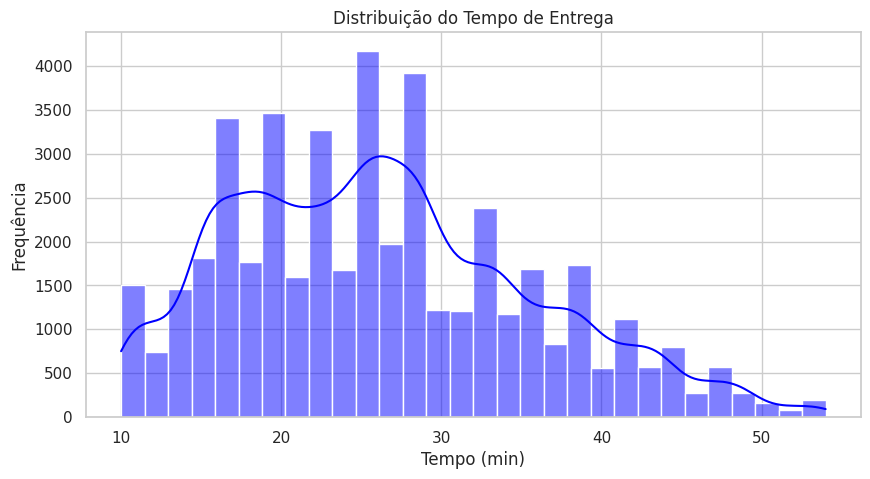

In [13]:
# Histograma do tempo de entrega
plt.figure(figsize=(10, 5))
sns.histplot(df['Time_taken(min)'], bins=30, kde=True, color='blue')
plt.title('Distribuição do Tempo de Entrega')
plt.xlabel('Tempo (min)')
plt.ylabel('Frequência')
plt.show()

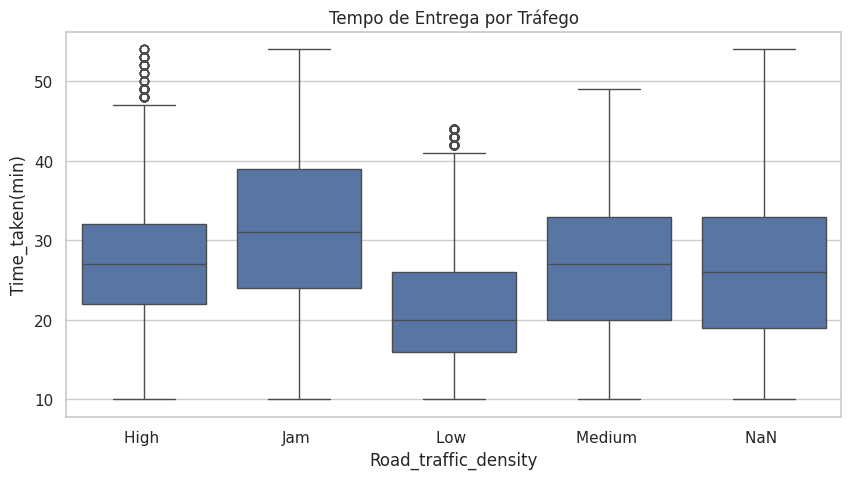

In [14]:
# Boxplot por densidade de tráfego
plt.figure(figsize=(10, 5))
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=df)
plt.title('Tempo de Entrega por Tráfego')
plt.show()

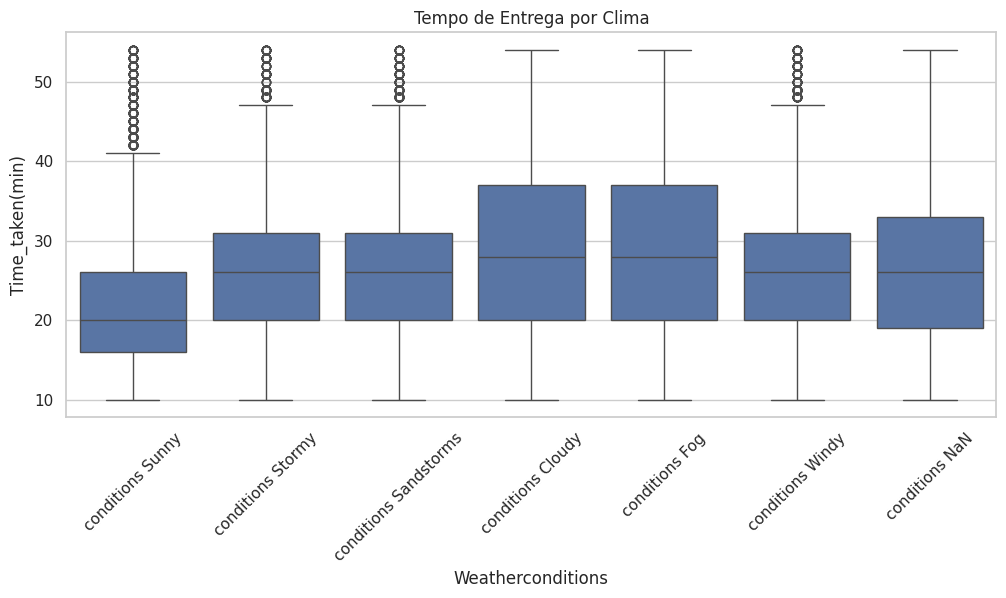

In [15]:
# Boxplot por condição climática
plt.figure(figsize=(12, 5))
sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=df)
plt.title('Tempo de Entrega por Clima')
plt.xticks(rotation=45)
plt.show()

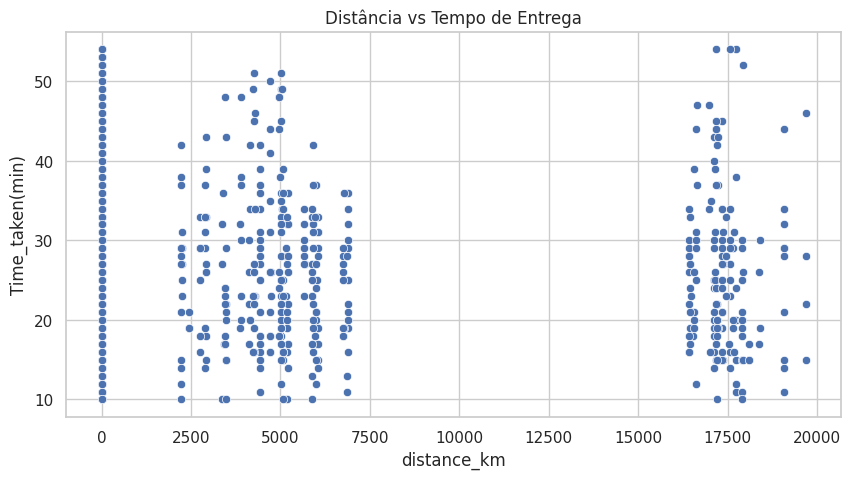

In [17]:
# Scatter distância x tempo
plt.figure(figsize=(10, 5))
sns.scatterplot(x='distance_km', y='Time_taken(min)', data=df)
plt.title('Distância vs Tempo de Entrega')
plt.show()

# Modelagem

In [18]:
features = [
    'Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
    'Weatherconditions', 'Road_traffic_density', 'Type_of_order',
    'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City',
    'waiting_time', 'distance_km'
]
target = 'Time_taken(min)'

In [19]:
df_model = df[features + [target]].dropna()
df_encoded = pd.get_dummies(df_model[features])
X = df_encoded
y = df_model[target]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f} minutos')
print(f'RMSE: {rmse:.2f} minutos')
print(f'R²: {r2:.2f}')

MAE: 3.33 minutos
RMSE: 4.20 minutos
R²: 0.80


# Explicabilidade com SHAP

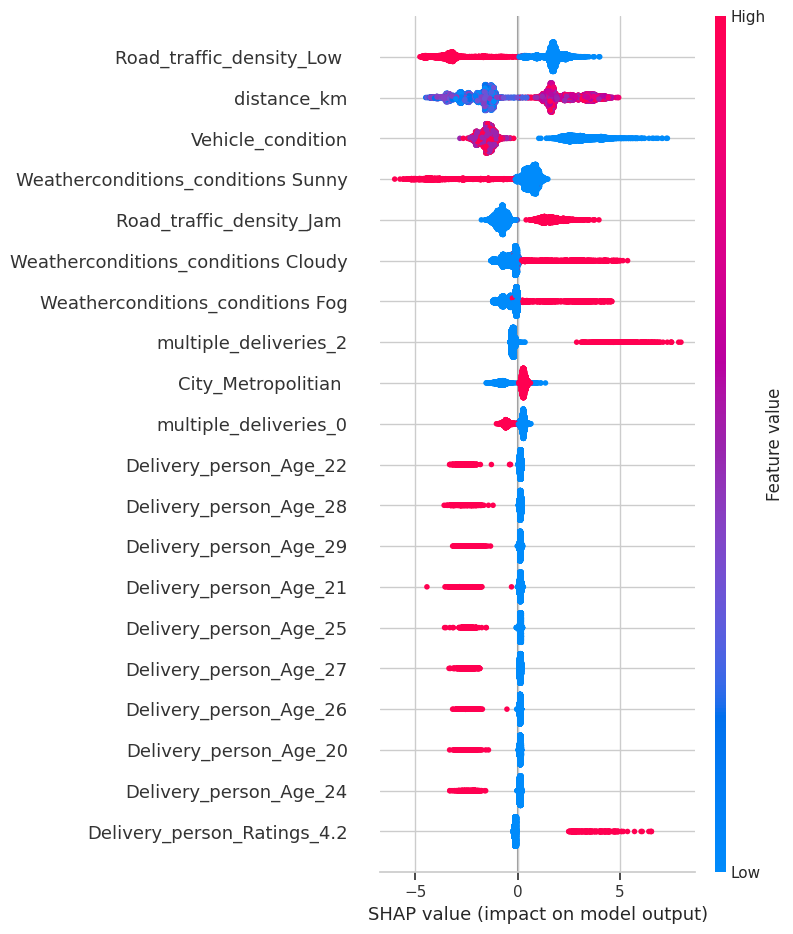

In [23]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Conclusão

- O modelo previu o tempo de entrega com MAE de ~3.3 minutos e R² de 80%.
- As variáveis com maior impacto são: densidade de tráfego, múltiplas entregas, distância e clima.
- Aplicações imediatas: melhoria no SLA do app, ajuste logístico e bonificação de entregadores.


# Insights Estratégicos

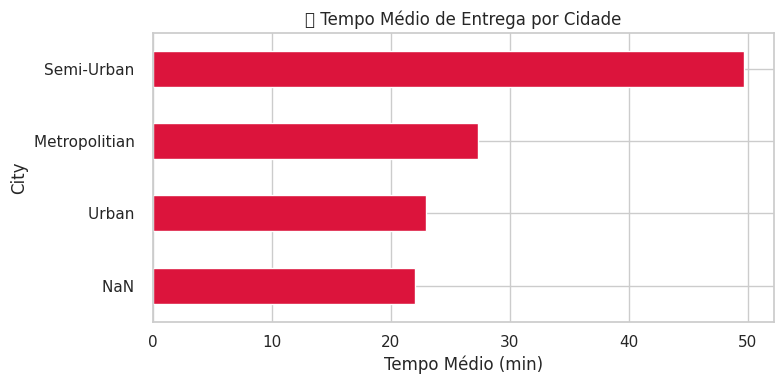

In [24]:
import matplotlib.pyplot as plt

# Cidades com maior tempo médio de entrega
city_delivery = df.groupby('City')['Time_taken(min)'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
city_delivery.plot(kind='barh', color='crimson')
plt.title('⏱️ Tempo Médio de Entrega por Cidade')
plt.xlabel('Tempo Médio (min)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

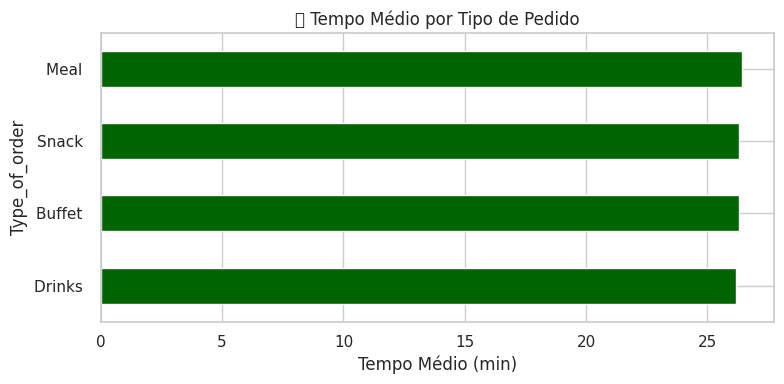

In [25]:
# Tipos de pedido com maior tempo médio
order_type = df.groupby('Type_of_order')['Time_taken(min)'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
order_type.plot(kind='barh', color='darkgreen')
plt.title('🍽️ Tempo Médio por Tipo de Pedido')
plt.xlabel('Tempo Médio (min)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

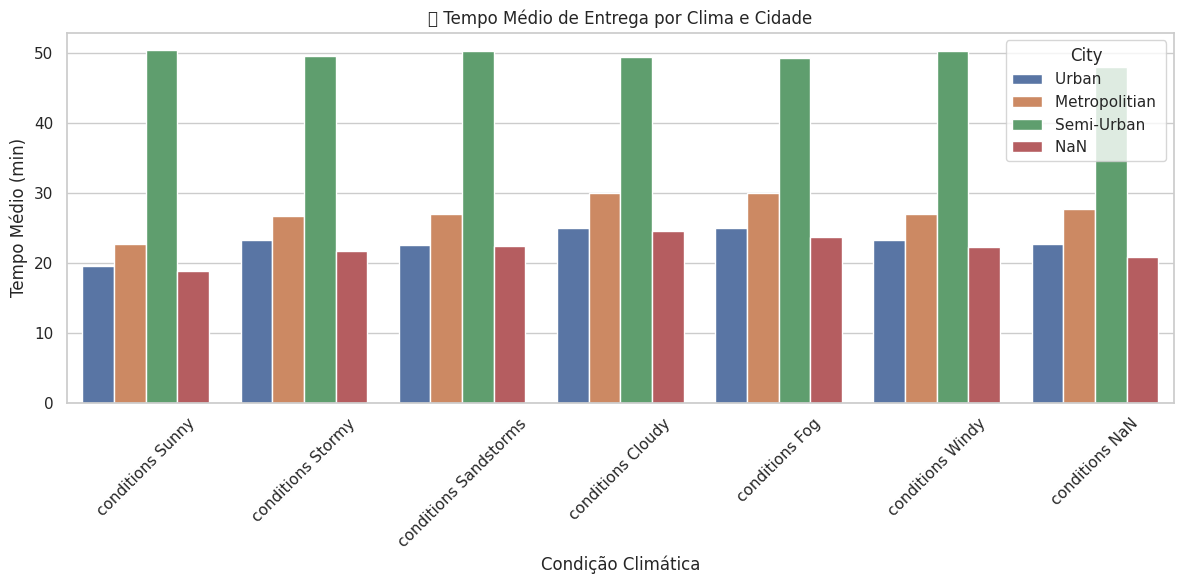

In [26]:
# Plot: Clima x Cidade x Tempo de Entrega
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Weatherconditions',
    y='Time_taken(min)',
    hue='City',
    data=df,
    ci=None
)
plt.title('⛅ Tempo Médio de Entrega por Clima e Cidade')
plt.ylabel('Tempo Médio (min)')
plt.xlabel('Condição Climática')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Salvar o modelo

In [30]:
import joblib

# Caminhos para salvar
caminho_modelo = 'modelo_xgboost_entrega.pkl'
caminho_colunas = 'colunas_modelo.pkl'

# Salvar modelo treinado
joblib.dump(model, caminho_modelo)

# Salvar lista de colunas usadas no X (ordenadas após one-hot encoding)
joblib.dump(X_train.columns.tolist(), caminho_colunas)

print("✅ Modelo e colunas salvos com sucesso!")

✅ Modelo e colunas salvos com sucesso!
